In [1]:
!pip install collections
!pip install geoutils

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
  Using cached geoutils-0.1.3-py3-none-any.whl.metadata (7.8 kB)
Using cached geoutils-0.1.3-py3-none-any.whl (90 kB)


In [2]:
import pyproj
from pyproj import Proj, transform
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from scipy import interpolate
from datetime import date, datetime, timedelta
from sklearn import linear_model
#from collections import Iterable 
import rasterio as rio
from datetime import date, datetime, timedelta
import glob as glob
from pyproj import Transformer
import geoutils as gu
from skimage.draw import line
import geopandas as gpd

In [3]:
# Load bed, dem, sat image, and velocities
proj_alaska = 3338
thick = gu.Raster('thickness_ares_uaf_spline_low_smooth.tif').reproject(crs=proj_alaska)
sat_image = gu.Raster('S1A_IW_20230823T025520_DVP_RTC30_G_gdufem_1CFD_VV.tif').reproject(thick, nodata = np.nan)
vels_ds = xr.open_dataset('Hubbard_SBAS.nc')
thick.data.data[thick.data.mask == True] = np.nan
json_layer = gpd.read_file('traces.geojson')
glacier_bounds = gu.Vector('glacier_bounds.geojson').reproject(thick)

/srv/conda/envs/notebook/lib/python3.11/site-packages/geoutils/raster/raster.py:389: UserWarning: One raster has a pixel interpretation "Area" and the other "Point". To silence this warning, either correct the pixel interpretation of one raster, or deactivate warnings of pixel interpretation with geoutils.config["warn_area_or_point"]=False.
  warnings.warn(message=msg, category=UserWarning)


In [4]:
vect_rasterized = glacier_bounds.create_mask(thick)
vect_mask = vect_rasterized.data.data.copy()
thickness = thick.data.data.copy()
thickness[vect_mask==False] = np.nan


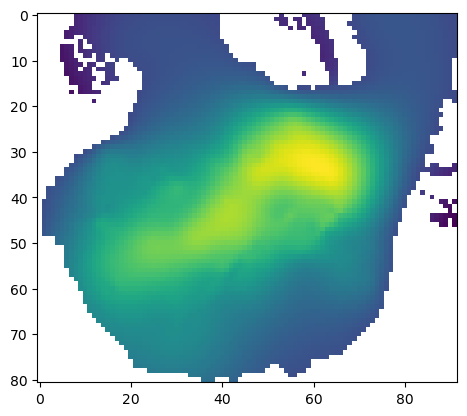

In [5]:
plt.imshow(thickness)

In [6]:
rast = gu.Raster.from_array(data=thickness, transform=thick.transform, crs=thick.crs, nodata=np.nan)
thick = rast.copy()

In [8]:
from ipyleaflet import Map, Marker, basemaps, AwesomeIcon, basemap_to_tiles, ImageOverlay, GeoJSON, GeoData
from ipywidgets import HTML
from IPython.display import display
import ipyleaflet as ipyl
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
import PIL
import PIL.Image
from io import StringIO, BytesIO
from base64 import b64encode
import json



# Code to display arrays on ipyleaflet maps, from https://github.com/jupyter-widgets/ipyleaflet/issues/705

def project_array(array, bounds, refinement=2):
    """
    Project a numpy array defined in WGS84 coordinates to Mercator Web coordinate system
    
    ipyleaflets use the Mercator Web coordinate system.
    :arg array: Data in 2D numpy array
    :arg bounds: Image latitude, longitude bounds, [(lat_min, lon_min), (lat_max, lon_max)]
    :kwarg int refinement: Scaling factor for output array resolution.
        refinement=1 implies that output array has the same size as the input.
    """
    with rio.Env():

        (lat_min, lon_min), (lat_max, lon_max) = bounds
        nlat, nlon = array.shape
        dlat = (lat_max - lat_min)/nlat
        dlon = (lon_max - lon_min)/nlon
        src_transform = A.translation(lon_min, lat_min) * A.scale(dlon, dlat)
        src_crs = {'init': 'EPSG:4326'}

        nlat2 = nlat*refinement
        nlon2 = nlon*refinement
        dst_shape = (nlat2, nlon2)
        dst_crs = {'init': 'EPSG:3857'}
        bbox = [lon_min, lat_min, lon_max, lat_max]
        dst_transform, width, height = rio.warp.calculate_default_transform(
            src_crs, dst_crs, nlon, nlat, *bbox, dst_width=nlon2, dst_height=nlat2)
        dst_shape = height, width
        destination = np.zeros(dst_shape)

        reproject(
            array,
            destination,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)
        return destination


def make_imageoverlay(array, bounds, mask=None, colormap='Blues', proj_refinement=4):
    """
    Make ImageOverlay from numpy array.
    
    
    :arg array: Data in 2D numpy array.
    :arg bounds: Image latitude, longitude bounds, [(lat_min, lon_min), (lat_max, lon_max)]
    :kwarg mask: Optional mask to mark missing data in the array. If mask=None and array is
        a masked array, its mask is used instead.
    :kwarg colormap: matplotlib colormap
    :kwarg int refinement: Scaling factor for output array resolution.
        refinement=1 implies that output array has the same size as the input.
    """
    if mask is None and hasattr(array, 'mask'):
        mask = array.mask
    # project to Mercator Web coordinates
    array_proj = project_array(array, bounds, refinement=proj_refinement)
    # map data to colors
    norm = plt.Normalize()
    cmap = plt.get_cmap(colormap)
    array_mapped = cmap(norm(array_proj))
    # convert to 8 bit int
    array_int = np.uint8(array_mapped*255)
    # make an image
    im = PIL.Image.new('RGBA', array_proj.shape[::-1], color=None)
    im_data = PIL.Image.fromarray(array_int)
    im_mask = None
    if mask is not None:
        assert mask.shape == array.shape, 'array and mask shapes must be identical'
        mask = project_array(mask.astype(float), bounds, refinement=proj_refinement)
        # NOTE image mask marks non-masked pixels
        mask_int = np.uint8(255*(1 - mask).astype(float))
        im_mask = PIL.Image.fromarray(mask_int, mode='L')
    im.paste(im_data, mask=im_mask)
    # store image in memory
    f = BytesIO()
    im.save(f, 'png')
    data = b64encode(f.getvalue())
    data = data.decode('ascii')
    imgurl = 'data:image/png;base64,' + data
    io = ImageOverlay(url=imgurl, bounds=bounds)
    return io



# Create a rotating array of colors to differenciate the markers
colors = ['red', 'green', 'blue', 'purple', 'gray', 'orange', 'beige']


# Create an empty list to store the markers
markers = []
temp_list = []
counter = 0

# Create a map
m = ipyl.Map(basemap=basemaps.Esri.WorldImagery, center=(0, 0), zoom=2)
m.scroll_wheel_zoom = True

# Function to handle click events
def handle_click(**kwargs):
    global counter
    global temp_list
    
    if kwargs.get('type') == 'click':
        
        icon = AwesomeIcon(name='fa-cog', marker_color = colors[counter])
        coords = kwargs.get('coordinates')
        marker = Marker(location=coords, icon=icon, draggable = True)
        temp_list.append(marker)
        
        if len(temp_list) == 2:
            markers.append(temp_list)     
            temp_list = []
            counter += 1
        m.add_layer(marker)
        
        display(HTML("Point added at coordinates: {}".format(coords)))

# Function to handle drag events
def handle_drag(event, marker):
    new_coords = marker.location
    index = markers.index(marker)
    points[index] = new_coords
    print("Marker {} dragged to coordinates: {}".format(index, new_coords))

# Add click event handler to the map
m.on_interaction(handle_click)

# Bind drag event handler to each marker
for marker in markers:
    marker.on_drag(handle_drag)
    
#### Display thickness on map

# Name of your thickness file in the Thickness folder
name_file = 'thickness_hubbard'
# Format of the file (without the ".", ex: "tif")
format = 'tif'
# Open thickness tif and reproject it to the right CRS
thickness =  xr.open_dataarray(f"{name_file}.{format}").rio.reproject(f"EPSG:4326").sel(band=1)
# We have to flip the array in order to have it displayed correctly
array = np.flip(thickness.values, axis = 0)
# For a reason, if there are NaNs the array is not displayed on the map. We change NaNs to value and mask this value out
array[np.isnan(array)] = np.nanmin(array) - 1
mask = array<=np.nanmin(array)
# Grab the extent of the array
bounds = [(thickness.y.values.min(), thickness.x.values.min()), (thickness.y.values.max(), thickness.x.values.max())]
# Create the layer containing the array
io = make_imageoverlay(array, bounds, mask=mask, colormap='viridis')
# Add layer to map
m.add_layer(io)
####

# Add radar traces
geo_json = ipyl.GeoData(geo_dataframe = json_layer,
                    point_style={'radius': 3, 'color': 'amber', 'opacity':1})
m.add_layer(geo_json)


# Display the map
display(m)



Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [9]:
# Choose amount of points you want on your transect
num_points = 40

In [10]:
points = [[(marker.location[0], marker.location[1]) for marker in points] for points in markers]


In [11]:
import pyproj
import numpy as np
import pandas as pd


def interpolate_points(x1, y1, x2, y2, num_points):
    # Generate num_points equally spaced points between (x1, y1) and (x2, y2)
    x_values = np.linspace(x1, x2, num_points)
    y_values = np.linspace(y1, y2, num_points)
    return list(zip(x_values, y_values))

def get_equally_spaced_points(points, num_points):
    interpolated_points = []
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i + 1]
        interpolated_points.extend(interpolate_points(x1, y1, x2, y2, num_points))
    return interpolated_points


# Function to find index of closest value
def find_closest_index(arr, value):
    return np.abs(arr - value).argmin()


def get_indices_fluxgate(ds, sat_image, points, num_points, color):
    # Define the source and target coordinate reference systems (CRS)
    src_crs = pyproj.CRS('EPSG:4326')
    target_crs = ds.crs

    # Define the transformer to transform coordinates from source CRS to target CRS
    transformer = pyproj.transformer.Transformer.from_crs(src_crs, target_crs, always_xy = True)
    
    equally_spaced_points = get_equally_spaced_points(points, num_points)

    # Transform the coordinates to the target CRS
    transformed_points = [transformer.transform(p[1], p[0]) for p in equally_spaced_points]

    # Extract x and y coordinates from the transformed points
    transformed_x = [p[0] for p in transformed_points]
    transformed_y = [p[1] for p in transformed_points]

    # Extract x, y coordinates of the tif
    dsx = ds.coords()[0][0,:]
    dsy = ds.coords()[1][:,0]

    # Find indices for x_long closest to X
    indices_x = [find_closest_index(dsx, val) for val in transformed_x]

    # Find indices for y_long closest to Y
    indices_y = [find_closest_index(dsy, val) for val in transformed_y]
    
    # Indices array
    crossed_points = [(x,y) for x,y in zip(indices_x, indices_y)]
    
    return crossed_points, transformed_points



def Fluxgate(th_points, tr, deltax, deltay, k = 1):

    flux = np.nansum(th_points * k * (tr.vx.values * deltay - tr.vy.values * deltax),axis=1)
    fluxpt = np.nansum(th_points * k * (tr.vx.values * deltay - tr.vy.values * deltax) ,axis=0)
    
    # Calculate flux for the dataset
    return np.abs(flux), np.abs(th_points), np.abs(fluxpt)




def Flux_Calculate(points, vels_ds, num_points):
    
    flux_list = []
    fluxpt_list = []
    tr_list = []
    dist_list = []
    thickness_list = []
    vels_list = []
    pts_list = []
    
    for p in range(len(points)):

        # Get the indices of the points in the datasets
        pts, coords_pts = get_indices_fluxgate(thick, sat_image, points[p], num_points, colors[p])
        pts_list.append(pts)
        x_thick = thick.coords()[0][0,:]
        y_thick = thick.coords()[1][:,0]

        source_proj = thick.crs  # Assuming the coordinates are in EPSG:4326 (WGS84)
        target_proj = pyproj.crs.CRS(vels_ds.attrs['projection'])  # Assuming vels.attrs['projection'] contains the target EPSG code

        # Define the transformer to transform coordinates from source CRS to target CRS
        transformer = pyproj.transformer.Transformer.from_crs(source_proj, target_proj, always_xy = True)

        # Transform the coordinates to the target CRS
        reprojected_coords = [transformer.transform(p[0], p[1]) for p in coords_pts]

        # Calculate thickness of ice
        thickness = np.array([thick.data.data[point[1],point[0]] for point in pts])
        #thickness[thickness==np.max(thickness)]=np.nan
        thickness = (thickness[1:] + thickness[:-1]) / 2

        # Save pts as dataframe
        pts = pd.DataFrame(reprojected_coords, columns=['x', 'y'])

        deltax = np.diff(pts.x.values)
        deltay = np.diff(pts.y.values)
        xmid = pts.x.values[0:-1] + deltax*0.5
        ymid = pts.y.values[0:-1] + deltay*0.5

        # Update the coordinates at which we calculate flux
        pts = pd.DataFrame({'x':xmid, 'y':ymid})

        # From the velocity dataset, extract values of points at the fluxgate
        tr = vels_ds.sel(y=xr.DataArray(pts.y.values, dims='z'), 
                            x=xr.DataArray(pts.x.values, dims='z'), 
                            method='nearest'
                            ).interpolate_na(dim="z", method="nearest").interpolate_na(dim='time', method='cubic')


        # Calculate flux
        flux, thpoints, fluxpt = Fluxgate(thickness, tr, deltax, deltay)

        # Create a date vector for plotting
        drange = tr.time.values
        dist = [np.sqrt((pts.x[i]-pts.x[i-1])**2+(pts.y[i]-pts.y[i-1])**2) for i in range(1,len(pts))]
        dist = np.array(np.hstack((np.array([0]), np.cumsum(dist))))

        # Sum vels
        vels = np.nanmean(np.sqrt((tr.vx.values**2 +  tr.vy.values**2)),axis=1)
        
        # Save in lists
        dist_list.append(dist)
        flux_list.append(flux)
        fluxpt_list.append(fluxpt)
        tr_list.append(tr)
        thickness_list.append(thickness)
        vels_list.append(vels)

    # Create bed array with NaNs
    test = thick.data.data.copy()
    test[test==np.nanmin(test)]=np.nan
    # Generate figure showing points generated
    plt.figure()
    plt.imshow(sat_image.data.data)
    plt.imshow(test, cmap = 'jet')
    for p in range(len(points)):
        for x,y in pts_list[p]:
            plt.scatter(x,y, color = colors[p])

    plt.figure()
    # Plotting flux
    for p in range(len(points)):
        vels_tr = np.nansum(np.sqrt(tr_list[p].vx.values**2 + tr_list[p].vy.values**2), axis = 0)
        plt.plot(dist_list[p], (vels_tr - np.nanmin(vels_tr)) / (np.nanmax(vels_tr) - np.nanmin(vels_tr)), color = colors[p])
    plt.ylabel('Normalized velocities along fluxgate')
    plt.xlabel('Distance along transect [m]')
    plt.ylim(bottom=0)
    #plt.legend(loc='upper left')

    # Adding ice thickness plot on secondary y-axis
    plt.twinx()
    for p in range(len(points)):
        plt.plot(dist_list[p], thickness_list[p], color=colors[p], linestyle='--', alpha=0.5, label='Ice thickness')
    plt.ylabel('Ice thickness (low-opacity curves)')
    plt.title('Flux and Ice Thickness along Distance [m]')

    # Adding legends
    #plt.legend(loc='lower left')
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.show()


    plt.figure()
    # Plotting flux
    for p in range(len(points)):
        plt.plot(tr_list[p].time, flux_list[p]/1e9, label = 'Transect flux in time', color = colors[p])
    plt.ylabel(f"Flux [km3/year]")
    plt.xlabel('Time')
    #plt.ylim(bottom=0)


    # Adding legends
    plt.legend(loc='upper left')
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.title('Total flux along transect in time')
    plt.show()
    
    plt.figure()
    # Plotting flux
    for p in range(len(points)):
        plt.plot(tr_list[p].time, vels_list[p], label = 'Average velocity transect in time', color = colors[p])
    plt.ylabel(f"Velocity [m/yr]")
    plt.xlabel('Time')
    #plt.ylim(bottom=0)


    # Adding legends
    plt.legend(loc='upper left')
    plt.tight_layout()  # Adjust layout to prevent overlapping labels
    plt.title('Average velocity of transect in time')
    plt.show()


    return flux, fluxpt, vels, dist

/tmp/ipykernel_112/1211325394.py:130: RuntimeWarning: Mean of empty slice
  vels = np.nanmean(np.sqrt((tr.vx.values**2 +  tr.vy.values**2)),axis=1)
/tmp/ipykernel_112/1211325394.py:130: RuntimeWarning: Mean of empty slice
  vels = np.nanmean(np.sqrt((tr.vx.values**2 +  tr.vy.values**2)),axis=1)
/tmp/ipykernel_112/1211325394.py:130: RuntimeWarning: Mean of empty slice
  vels = np.nanmean(np.sqrt((tr.vx.values**2 +  tr.vy.values**2)),axis=1)
/tmp/ipykernel_112/1211325394.py:130: RuntimeWarning: Mean of empty slice
  vels = np.nanmean(np.sqrt((tr.vx.values**2 +  tr.vy.values**2)),axis=1)


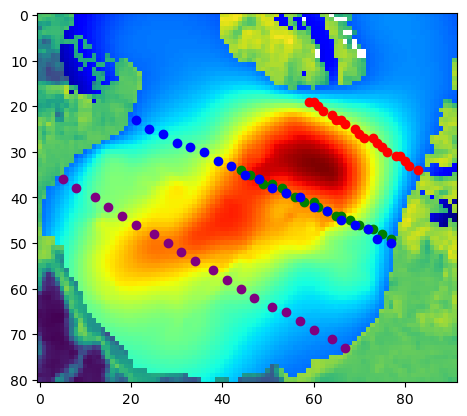

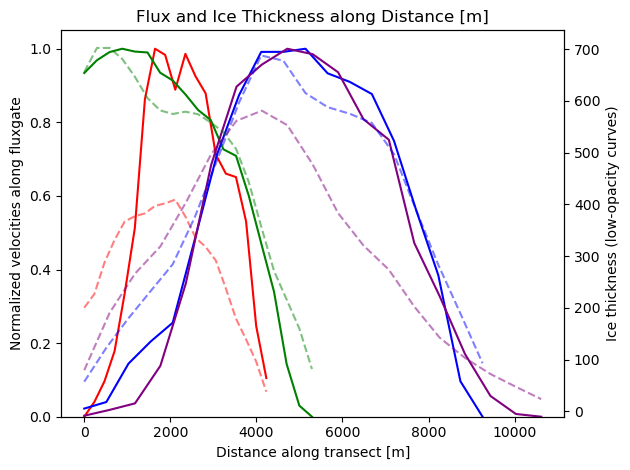

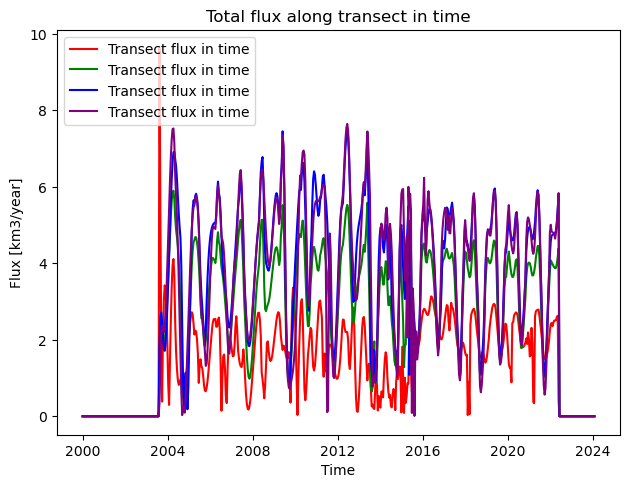

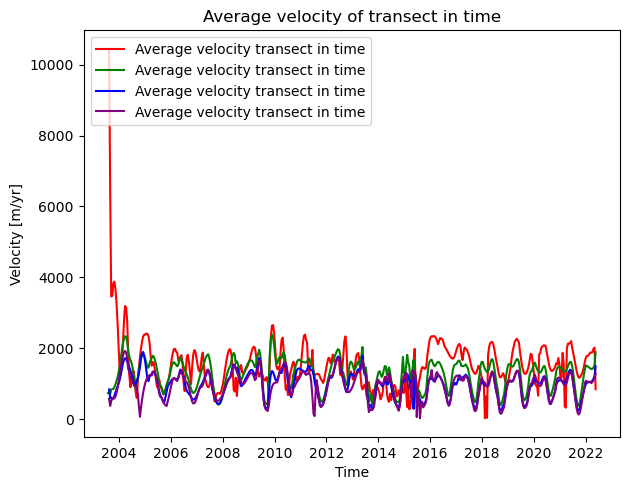

In [12]:
flux, fluxpt, vels, dist = Flux_Calculate(points, vels_ds, 20)

In [13]:
# Slip coefficient
slip_coefficient = 1

# Velocity threshold for automatic glacier edges
threshold = 200

# Timestep for ODE solving (resolution of thickness inversion)
timestep = 0.005

# Maximum of the eval range (years)
tevalmax = 20

# streamline direction (-1: upstream, 1: downstream)
sd = -1


In [14]:
from ipywidgets import Button

flag = 'transect'
def handle_click(**kwargs):
    global i
    global n
    global c
    # If left click, add marker, grab coordinates and store in the coordinates array
    # Ideally, I would like 'click' to be 'leftclick' if that exists
    if kwargs.get('type') == 'click':
        
        if flag == 'transect':
            icon = AwesomeIcon(name='fa-cog', marker_color = 'red')
            m.add_layer(Marker(location=kwargs.get('coordinates'), icon=icon,  draggable=True))
            coordinates_fluxgate.append(kwargs['coordinates'])
            i += 1
        elif flag == 'seed':
            icon = AwesomeIcon(name='fa-cog', marker_color = 'green')
            m.add_layer(Marker(location=kwargs.get('coordinates'), icon=icon,  draggable=True))
            coordinates_seed.append(kwargs['coordinates'])
            i += 1           

    
    # If right click, change color of marker, change column in coordinates, reinitialize the row counter
    elif kwargs.get('type') == 'contextmenu':
        i = 0
        n += 1
        c += 1
        if c > len(colors)-1:
            c = 0


# Initialize coordinates array
coordinates_fluxgate=[]
coordinates_seed=[]

# Initialize indices
i = 0
n = 0
c = 0
# Create a rotating array of colors to differenciate the markers
colors = ['red', 'green', 'blue', 'purple', 'gray', 'orange', 'beige']

# plot the map
m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.WorldImagery),
    zoom=3,
    scroll_wheel_zoom=True
    ) 


# plot the AOI
# Define a function to handle button click
def on_button_click(b):
    global flag
    flag = 'seed'

# Create the button
button = Button(description="Seed Flowline")

# Connect the button to the click handler function
button.on_click(on_button_click)

# Add radar traces
geo_json = ipyl.GeoData(geo_dataframe = json_layer,
                    point_style={'radius': 3, 'color': 'amber', 'opacity':1})
m.add_layer(geo_json)

# Display the button
display(button)
m.add_layer(io)
m.on_interaction(handle_click)
m

Button(description='Seed Flowline', style=ButtonStyle())

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [20]:
# Extract the first and second values of the x-coordinate from vels_ds
x_start = vels_ds.x.values[0]
x_end = vels_ds.x.values[-1]
y_start = vels_ds.y.values[-1]
y_end = vels_ds.y.values[0]

# Select a slice along the 'x' dimension using the extracted values
ds = xr.open_dataset('ALA_G0120_0000.nc').sel(x=slice(x_start, x_end), y=slice(y_start, y_end))

In [24]:
# Get the indices of the points in the datasets
pts, coords_pts = get_indices_fluxgate(thick, sat_image, coordinates_fluxgate, 20, 'red')
x_thick = thick.coords()[0][0,:]
y_thick = thick.coords()[1][:,0]

source_proj = thick.crs  # Assuming the coordinates are in EPSG:4326 (WGS84)
target_proj = pyproj.crs.CRS('3413')  # Assuming vels.attrs['projection'] contains the target EPSG code

# Define the transformer to transform coordinates from source CRS to target CRS
transformer = pyproj.transformer.Transformer.from_crs(source_proj, target_proj, always_xy = True)

# Transform the coordinates to the target CRS
reprojected_coords = [transformer.transform(p[0], p[1]) for p in coords_pts]

# Calculate thickness of ice
thickness = np.array([thick.data.data[point[1],point[0]] for point in pts])
thickness = (thickness[1:] + thickness[:-1]) / 2

# Save pts as dataframe
pts = pd.DataFrame(reprojected_coords, columns=['x', 'y'])

deltax = np.diff(pts.x.values)
deltay = np.diff(pts.y.values)
xmid = pts.x.values[0:-1] + deltax*0.5
ymid = pts.y.values[0:-1] + deltay*0.5

# Update the coordinates at which we calculate flux
pts = pd.DataFrame({'x':xmid, 'y':ymid})

# From the velocity dataset, extract values of points at the fluxgate
tr = ds.sel(y=xr.DataArray(pts.y.values, dims='z'), 
                    x=xr.DataArray(pts.x.values, dims='z'), 
                    method='nearest')

# Calculate velocity 

Q = np.nansum(thickness * 1 * (tr.vx.values * deltay - tr.vy.values * deltax))



# Grab the velocity arrays
vx = ds.vx.values
vy =  ds.vy.values
x = ds.x.values
y = ds.y.values

# Create an empty array of bed values the size of the velocity array
thickness_propagated = np.full([vx.shape[0], vx.shape[1]], np.nan)


source_proj = 4326  # Assuming the coordinates are in EPSG:4326 (WGS84)
target_proj = pyproj.crs.CRS('3413')  # Assuming vels.attrs['projection'] contains the target EPSG code

# Define the transformer to transform coordinates from source CRS to target CRS
transformer = pyproj.transformer.Transformer.from_crs(source_proj, target_proj, always_xy = True)

# Transform the coordinates to the target CRS
coords_seed = [transformer.transform(p[1], p[0]) for p in coordinates_seed]



from scipy.interpolate import RegularGridInterpolator
X, Y = np.meshgrid(x, y)
fx = RegularGridInterpolator((y, x), vx, bounds_error=False, fill_value=None)
fy = RegularGridInterpolator((y, x), vy, bounds_error=False, fill_value=None)

# define the velocity function to be integrated, according to the streamline direction
def f(t, y):
    return np.squeeze([fy(y), fx(y)]) * sd

# Maximum of the eval range (years)
tevalmax = 5
# Timestep for ODE solving (resolution of thickness inversion)
timestep = 0.01

from scipy.integrate import solve_ivp
sol = solve_ivp(f, [0, tevalmax], [coords_seed[0][1],coords_seed[0][0]], t_eval=np.arange(0,tevalmax,timestep))

# Get inds of streamline
inds = np.array([(np.abs(y - sol.y[0,i]).argmin(), np.abs(x - sol.y[1,i]).argmin()) for i in range(len(sol.y[0]))])

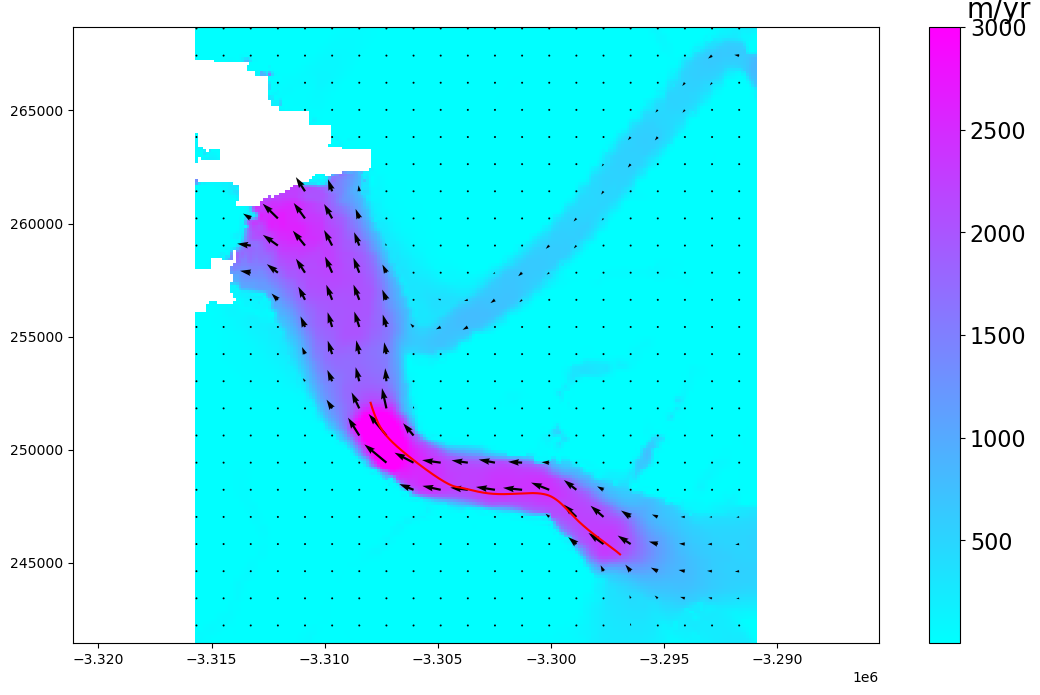

In [26]:
plt.figure(figsize=(13,8))

plt.pcolormesh(x,y,np.sqrt(vx**2 + vy**2), shading='nearest', vmax=3000, alpha=1, cmap='cool')
clb=plt.colorbar()
clb.set_label('m/yr', labelpad=-20, y=1.05, rotation=0, fontsize=20)
clb.ax.tick_params(labelsize=16)
plt.quiver(x[::10],y[::10],vx[::10,::10],vy[::10,::10],scale=100000)
plt.axis('equal')
plt.plot(sol.y[1,:],sol.y[0,:],'r')

In [27]:
def streamliner(c, threshold):

    # Gather coordinates of streamline point 
    I= inds[c,0]
    J = inds[c,1]


    # Calculate the coefficients of the line equation from the point's coordinates and its velocity vector
    a = vx[I,J]/vy[I,J]
    b = I - a * J

    # Find the intersection of the line with the edges of the matrix
    y1 = 0
    y2 = vx.shape[0]
    x1 = int(-b/a)
    x2 = int((y2-b)/a)

    # Collect all points between the two points at which the line intersects the velocity's edges
    inds_line = np.array(line(y1, x1, y2, x2))

    # Remove all points outside of the velocity's edges
    inds_line = np.array([inds_line[i,np.where(np.logical_and(inds_line[1]>=0, inds_line[1]<=vx.shape[1]-1))[0][:].astype('int')] for i in range(2)]).astype('int')

    # Grab the index of the streamline point in inds_line
    ind_stream = np.abs(inds_line[0,:] - I).argmin()

    # Find the first edge of the glacier
    for e1 in range(ind_stream+1, len(inds_line[0])-1):
        if np.sqrt(vx[inds_line[:,e1][0], inds_line[:,e1][1]]**2 + vy[inds_line[:,e1][0], inds_line[:,e1][1]]**2) < threshold:
            break

    # Find the second edge of the glacier
    for e2 in range(ind_stream-1, 0,-1):
            if np.sqrt(vx[inds_line[:,e2][0], inds_line[:,e2][1]]**2 + vy[inds_line[:,e2][0], inds_line[:,e2][1]]**2) < threshold:
                break

                
    return e1, e2, inds_line, c

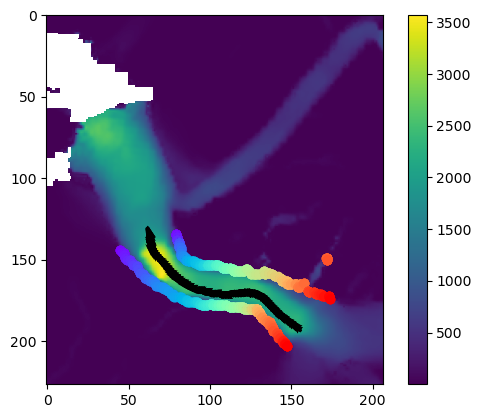

In [28]:
# Start figure
plt.figure()

# plot background velocities
plt.imshow(np.sqrt(vx**2 + vy**2))
plt.colorbar()

# Loop through X points along the streamline
X = len(sol.y[0])

# Create a custom colormap
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, X))

# Choose a threshold of minimum velocities to be considered as the edges of the glacier
threshold = 200 #[m/yr]

E1 = []
E2 = []

# Loop
for c, col in zip(range(0,X), colors):

    # Call the streamliner function
    e1, e2, inds_line, C = streamliner(c,threshold)
    
    # plot all lines computed that are perpendicular to the main flow
    #plt.plot(inds_line[1,:], inds_line[0,:])

    # plot velocity arrows of centerline points computed
    plt.quiver(inds[c,1],inds[c,0],vx[inds[c,0],inds[c,1]],vy[inds[c,0],inds[c,1]],scale=50000)

    # plot the edges of the glacier
    plt.scatter(inds_line[1,e1],inds_line[0,e1], color=col)
    plt.scatter(inds_line[1,e2],inds_line[0,e2], color=col)

    E1.append((inds_line[0,e1], inds_line[1,e1]))
    E2.append((inds_line[0,e2], inds_line[1,e2]))

In [29]:
def thickness_propagation(c):
    # Gather coordinates of streamline point 
    I= inds[c,0]
    J = inds[c,1]

    # Grab the velocity arrays
    vx = ds.vx.values
    vy = ds.vy.values

    # Calculate the coefficients of the line equation from the point's coordinates and its velocity vector
    a = vx[I,J]/vy[I,J]
    b = I - a * J

    # Find the intersection of the line with the edges of the matrix
    y1 = 0
    y2 = vx.shape[0]
    x1 = int(-b/a)
    x2 = int((y2-b)/a)

    # Collect all points between the two points at which the line intersects the velocity's edges
    inds_line = np.array(line(y1, x1, y2, x2))

    # Remove all points outside of the velocity's edges
    inds_line = np.array([inds_line[i,np.where(np.logical_and(inds_line[1]>=0, inds_line[1]<=vx.shape[1]-1))[0][:].astype('int')] for i in range(2)]).astype('int')

    # Grab the index of the streamline point in inds_line
    ind_stream = np.abs(inds_line[0,:] - I).argmin()

    # Find the first edge of the glacier
    for e1 in range(ind_stream+1, len(inds_line[0])):
        if np.sqrt(vx[inds_line[:,e1][0], inds_line[:,e1][1]]**2 + vy[inds_line[:,e1][0], inds_line[:,e1][1]]**2) < threshold:
            break

    # Find the second edge of the glacier
    for e2 in range(ind_stream-1, 0,-1):
            if np.sqrt(vx[inds_line[:,e2][0], inds_line[:,e2][1]]**2 + vy[inds_line[:,e2][0], inds_line[:,e2][1]]**2) < threshold:
                break

    # Grab all velocities between the two points
    if e1 < e2:
        inds_line = inds_line[:,e1:e2]
    else:
        inds_line = inds_line[:,e2:e1]

    vxline = vx[inds_line[0], inds_line[1]]
    vyline = vy[inds_line[0], inds_line[1]]
    vline = np.sqrt(vxline**2 + vyline**2)

    # Grab the index of the fastest velocity
    ind_max_vel_line = np.where(vline == np.nanmax(vline))[0][0]

    # Interpolate the velocities along one line
    x = np.arange(-ind_max_vel_line, len(vline)-ind_max_vel_line)
    fvx = interpolate.interp1d(x, vxline, 'quadratic') # Interpolate vx
    fvy = interpolate.interp1d(x, vyline, 'quadratic') # Interpolate vy
    xnew = np.arange(-ind_max_vel_line, len(vline)-ind_max_vel_line-1, 0.01) # Create new interpolation domain
    vxnew= fvx(xnew) # Interpolate vx
    vynew= fvy(xnew) # Interpolate vy
    vnew= np.sqrt(vxnew**2 + vynew**2) # Calculate the velocity

    # Update the index of fastest velocity according to xnew
    ind_max_vel = np.where(vnew == np.nanmax(vnew))[0][0]
    xmin = xnew[0]
    xmax = xnew[-1]

    # Calculate the spatial step of xnew in the dataset's projection
    dxnew = (np.sqrt((ds.x.values[inds_line[0,0]]-ds.x.values[inds_line[0,-1]])**2 + (ds.y.values[inds_line[1,0]]-ds.y.values[inds_line[1,-1]])**2))/len(xnew)

    # Angle between first and last value of xnew, compared to the array's X axis (sanity check: if the flow is East-West in epsg:3413, vy is perpendicular to the fluxgate and sin(alpha) = 0, therfore vx doesn't participate)
    alpha = np.arctan((ds.y.values[inds_line[0,-1]]-ds.y.values[inds_line[0,0]])/(ds.x.values[inds_line[1,-1]]-ds.x.values[inds_line[1,0]]))

    # Calculate the maximum depth along the transect
    d = Q / (slip_coefficient *  
        np.sum(
            (1 - (xnew[0:ind_max_vel]**2/(xmin**2)))  * np.abs((vxnew[0:ind_max_vel] * (dxnew*np.sin(alpha)) - vynew[0:ind_max_vel] * (dxnew*np.cos(alpha))))) + 
            np.sum(
                (1 - (xnew[ind_max_vel:]**2/(xmax**2)))  * np.abs((vxnew[ind_max_vel:] * (dxnew*np.sin(alpha)) - vynew[ind_max_vel:] * (dxnew*np.cos(alpha))))))

    # plug-in equations for 2 parabolas that we joint in their middle
    thickness = np.append((-d*x[0:ind_max_vel_line]**2)/xmin**2 + d, (-d*x[ind_max_vel_line:]**2)/((xmax)**2) + d)

    return thickness, inds_line, vline

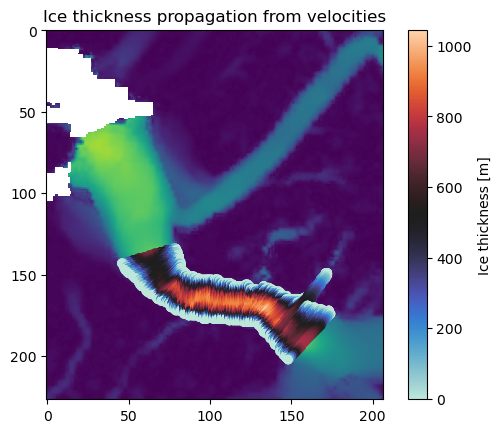

In [30]:
thickness_transects = []
v_transects = []
inds_pts_transects = []

for i in range(len(sol.y[0])):
    a,b,c = thickness_propagation(i)
    thickness_transects.append(a)
    inds_pts_transects.append(b)
    v_transects.append(c)
    
vm  = int(np.nanmax(np.array([np.nanmax(thickness_transects[i]) for i in range(len(thickness_transects))])))


plt.figure()
plt.title('Ice thickness propagation from velocities')
plt.imshow(np.sqrt(ds.v.values))


for i in range(len(thickness_transects)):
    plt.scatter(inds_pts_transects[i][1],inds_pts_transects[i][0], c=thickness_transects[i], cmap='icefire', vmax = vm)
plt.colorbar(label='Ice thickness [m]')